In [418]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt

In [419]:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")

In [420]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [421]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988,40.732,-73.990,40.757,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964,40.680,-73.960,40.655,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997,40.738,-73.986,40.730,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956,40.772,-73.986,40.730,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970,40.761,-73.962,40.756,N


In [422]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [423]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [424]:
test.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

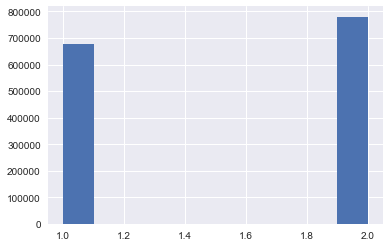

In [425]:
train['vendor_id'].hist()

In [426]:
train['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

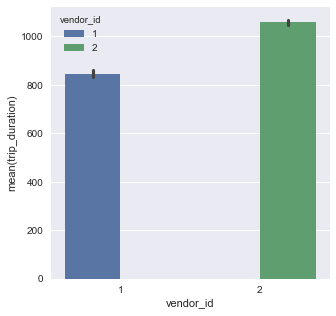

In [427]:
# vendorid having 2 seems to have a larger duration
fig,axes = plt.subplots(figsize = (5,5))
sns.barplot(data=train, x='vendor_id',y='trip_duration',hue='vendor_id')

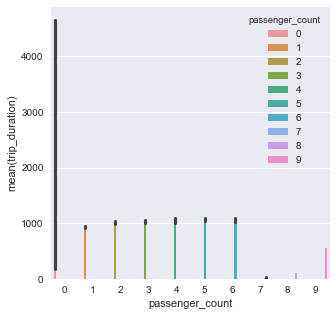

In [428]:
# Number of people fom 1 to 6 almost have same time to travel as opposed to 7 to 9.
fig,axes = plt.subplots(figsize = (5,5))
sns.barplot(data=train, x='passenger_count',y='trip_duration',hue='passenger_count')

NYC Border limits are such that 
city_long_border = (-74.03, -73.75) city_lat_border = (40.63, 40.85)
With that being defined, the rest of the other points we could sufficiently assume other datapoints are outliers.

In [429]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [430]:
train.shape

(1439183, 11)

In [377]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
print("Mean: {:.3f}  Standard Dev:{:.3f}".format(m,s))
Train = train[train['trip_duration'] <= m + 2*s]
Train = train[train['trip_duration'] >= m - 2*s]

Mean: 946.231  Standard Dev:5251.641


In [431]:
Train.shape

(1439183, 17)

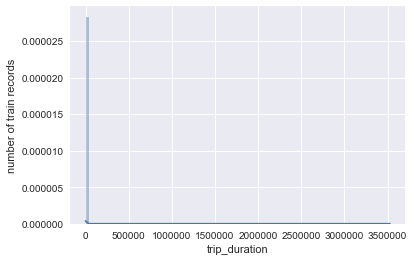

In [432]:
sns.distplot(a=train['trip_duration'],bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

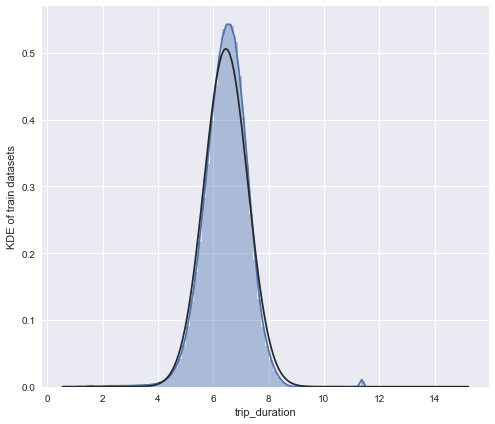

In [433]:
fig,axes = plt.subplots(figsize=(8,7))
plt.ylabel('KDE of train datasets')
plt.xlabel('log of Trip Duration')
sns.distplot(a=np.log1p(Train['trip_duration']),bins=100, fit=stats.norm)

In [381]:
Train['log_trip_duration'] = np.log1p(Train['trip_duration'])

In [382]:
Test = test

In [383]:
Train['pickup_datetime_converted'] =pd.to_datetime(Train['pickup_datetime']) 
Test['pickup_datetime_converted'] =pd.to_datetime(Test['pickup_datetime']) 

In [384]:
Train.loc[:, 'pickup_date'] = Train['pickup_datetime_converted'].dt.date
Test.loc[:, 'pickup_date'] = Test['pickup_datetime_converted'].dt.date

In [385]:
Train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_datetime_converted,pickup_date
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,6.122,2016-03-14 17:24:55,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,6.498,2016-06-12 00:43:35,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,7.662,2016-01-19 11:35:24,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,6.064,2016-04-06 19:32:31,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,6.078,2016-03-26 13:30:55,2016-03-26


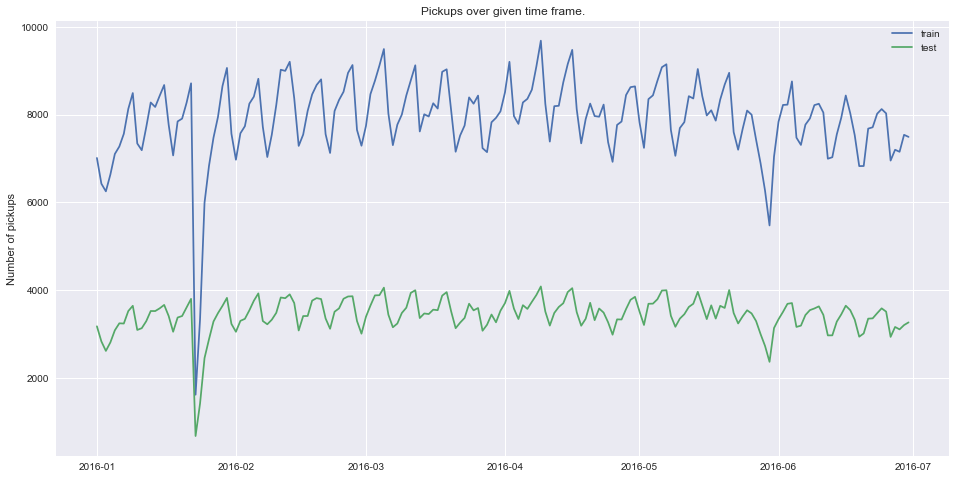

In [386]:
fig,axes = plt.subplots(figsize =(16,8))
plt.plot(Train.groupby('pickup_date').count()[['id']], 'x-', label='train')
plt.plot(Test.groupby('pickup_date').count()[['id']], 'x-', label='test')
plt.title('Pickups over given time frame.')
plt.legend(loc=0)
plt.ylabel('Number of pickups')

In [387]:
Train.groupby('vendor_id')['trip_duration'].mean()

vendor_id
1    833.503
2   1044.231
Name: trip_duration, dtype: float64

In [388]:
Train.groupby('store_and_fwd_flag')['trip_duration'].mean()

store_and_fwd_flag
N    945.569
Y   1066.472
Name: trip_duration, dtype: float64

In [389]:
Train.groupby('passenger_count')['trip_duration'].mean()

passenger_count
0   1880.925
1    917.370
2    990.569
3   1013.873
4   1037.515
5   1058.289
6   1050.980
Name: trip_duration, dtype: float64

In [390]:
Train.groupby('passenger_count').size()

passenger_count
0         53
1    1019950
2     207167
3      59104
4      28011
5      77127
6      47771
dtype: int64

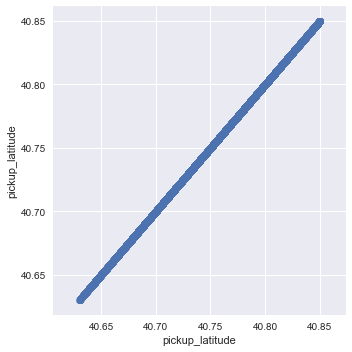

In [393]:
sns.lmplot(x='pickup_latitude',y = 'pickup_latitude',fit_reg=False,data=Train)

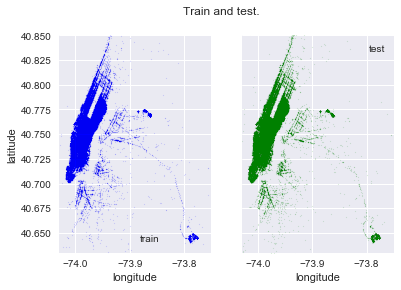

In [402]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(Train['pickup_longitude'].values[:N], Train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(Test['pickup_longitude'].values[:N], Test['pickup_latitude'].values[:N],
              color='green', s=1,label='test', alpha=0.1)
fig.suptitle('Train and test.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [404]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [406]:
Train.loc[:, 'distance_haversine'] = haversine_array(Train['pickup_latitude'].values, Train['pickup_longitude'].values, Train['dropoff_latitude'].values, Train['dropoff_longitude'].values)
Test.loc[:, 'distance_haversine'] = haversine_array(Test['pickup_latitude'].values, Test['pickup_longitude'].values, Test['dropoff_latitude'].values, Test['dropoff_longitude'].values)    
    
Train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(Train['pickup_latitude'].values, Train['pickup_longitude'].values, Train['dropoff_latitude'].values, Train['dropoff_longitude'].values)
Test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(Test['pickup_latitude'].values, Test['pickup_longitude'].values, Test['dropoff_latitude'].values, Test['dropoff_longitude'].values)

Train.loc[:, 'direction'] = bearing_array(Train['pickup_latitude'].values, Train['pickup_longitude'].values, Train['dropoff_latitude'].values, Train['dropoff_longitude'].values)
Test.loc[:, 'direction'] = bearing_array(Test['pickup_latitude'].values, Test['pickup_longitude'].values, Test['dropoff_latitude'].values, Test['dropoff_longitude'].values)

In [407]:
Train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_datetime_converted,pickup_date,distance_haversine,distance_dummy_manhattan,direction
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,6.122,2016-03-14 17:24:55,2016-03-14,1.499,1.735,99.970
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,6.498,2016-06-12 00:43:35,2016-06-12,1.806,2.431,-117.154
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,7.662,2016-01-19 11:35:24,2016-01-19,6.385,8.204,-159.680
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,6.064,2016-04-06 19:32:31,2016-04-06,1.485,1.661,-172.738
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,6.078,2016-03-26 13:30:55,2016-03-26,1.189,1.199,179.474
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.983,40.742,-73.992,40.749,N,443,6.096,2016-01-30 22:01:40,2016-01-30,1.099,1.554,-44.996
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969,40.758,-73.957,40.766,N,341,5.835,2016-06-17 22:34:59,2016-06-17,1.326,1.874,47.506
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969,40.798,-73.922,40.761,N,1551,7.347,2016-05-21 07:54:58,2016-05-21,5.715,8.079,136.385
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999,40.738,-73.986,40.733,N,255,5.545,2016-05-27 23:12:23,2016-05-27,1.310,1.775,118.284
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981,40.744,-73.973,40.790,N,1225,7.112,2016-03-10 21:45:01,2016-03-10,5.121,5.754,7.604


In [408]:
Test

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_datetime_converted,pickup_date,distance_haversine,distance_dummy_manhattan,direction
0,id3004672,1,2016-06-30 23:59:58,1,-73.988,40.732,-73.990,40.757,N,2016-06-30 23:59:58,2016-06-30,2.746,2.913,-3.595
1,id3505355,1,2016-06-30 23:59:53,1,-73.964,40.680,-73.960,40.655,N,2016-06-30 23:59:53,2016-06-30,2.759,3.105,172.279
2,id1217141,1,2016-06-30 23:59:47,1,-73.997,40.738,-73.986,40.730,N,2016-06-30 23:59:47,2016-06-30,1.306,1.846,133.326
3,id2150126,2,2016-06-30 23:59:41,1,-73.956,40.772,-73.986,40.730,N,2016-06-30 23:59:41,2016-06-30,5.269,7.163,-150.957
4,id1598245,1,2016-06-30 23:59:33,1,-73.970,40.761,-73.962,40.756,N,2016-06-30 23:59:33,2016-06-30,0.961,1.354,130.260
5,id0668992,1,2016-06-30 23:59:30,1,-73.991,40.750,-73.981,40.787,N,2016-06-30 23:59:30,2016-06-30,4.186,4.995,12.530
6,id1765014,1,2016-06-30 23:59:15,1,-73.978,40.742,-73.952,40.717,N,2016-06-30 23:59:15,2016-06-30,3.513,4.940,140.985
7,id0898117,1,2016-06-30 23:59:09,2,-74.013,40.702,-73.986,40.720,N,2016-06-30 23:59:09,2016-06-30,2.981,4.211,47.864
8,id3905224,2,2016-06-30 23:58:55,2,-73.992,40.731,-73.876,40.875,N,2016-06-30 23:58:55,2016-06-30,18.852,25.925,31.368
9,id1543102,2,2016-06-30 23:58:46,1,-73.993,40.749,-73.979,40.761,N,2016-06-30 23:58:46,2016-06-30,1.820,2.564,39.931


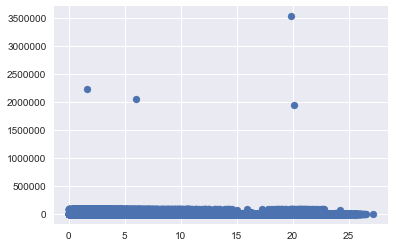

In [435]:
fig,axes = plt.subplots()
axes.scatter(x=Train['distance_haversine'].values,y=Train['trip_duration'].values)
plt.xlabel("Haver")

In [436]:
coords = np.vstack((Train[['pickup_latitude', 'pickup_longitude']].values,
                    Train[['dropoff_latitude', 'dropoff_longitude']].values,
                    Test[['pickup_latitude', 'pickup_longitude']].values,
                    Test[['dropoff_latitude', 'dropoff_longitude']].values))